<h1>Capstone Project - The Battle of Neighborhoods (Week 2)</h1>
<h3>Applied Data Science Capstone by IBM/Coursera</h3>

<h2>Table of contents</h2>
<ul>
    <li><a href="#introduction">Introduction: Business Problem</a></li>
    <li><a href="#data">Data</a></li>
    <li><a href="#methodology">Methodology</a></li>
    <li><a href="#analysis">Analysis</a></li>
    <li><a href="#results">Results and Discussion</a></li>
    <li><a href="#conclusion">Conclusion</a></li>
</ul>

<h2 id="introduction">Introduction: Bussiness Problem</h2><hr>
In Latin America some times the difficulties to find a good job or a job that pays enough to sustain a family properly is a big issue, for that reason many people use to migrate to the United States, regularly one single member is the one who looks to establish there and help their family. One common situation with this change of culture is the food, many of them look for places to eat the food they use to eat in their hometowns and that's not always easy to find.

This project has the goal to analyze Cincinnati, Ohio venues to establish which could be the best neighborhood to open a Latin American restaurant. To accomplish this objective we are going to analyze the status of each neighborhood regarding restaurants and Latin American restaurants, this will be made using the Foursquare API, to analyze the Cincinnati venues.

This project is aimed at entrepreneurs that are looking for opportunities to establish a new business in the food sector, so the result of this analysis will be data that helps them to choose the better option to start a new business.

<h2 id="data">Data</h2><hr>
The data required for this project will be obtained from different sources, which are listed below:
<h4>List of neighborhoods in Cincinatti</h4> 
<p>This data will be extracted from <a href="https://en.wikipedia.org/wiki/List_of_Cincinnati_neighborhoods" _"blank">Wikipedia</a>. From this list, we are going to use only the main neighborhoods, and discard the subclassification listed on that page. To get this data we are going to use BeautifulSoup to do the web scraping. An example of the data is listed next:<br><img src="https://www.dropbox.com/s/5g55da5sfd9hxla/Screen%20Shot%202021-02-02%20at%2022.53.35.png?raw=1"><br></p>

To get the list of Cincinnati neighborhoods from the Wikipedia page let's start doing an import of the necessary libraries.

In [1]:
# importing the BeautifulSoup library to parse the HTML document in page variable
from bs4 import BeautifulSoup
# importing library to open URLs
import urllib.request
# importing pandas dataframes
import pandas as pd

Now let's scrap the Wikipedia page using BeautifulSoup. The data is into an HTML list, so we are going to get all the list elements using the HTML tag &lt;li&gt;. After obtained each of these elements we are going to extract the text inside the tags using the <code>get_text()</code> function, to finally create a dataframe name df.

In [3]:
# Wikipedia url
url = "https://en.wikipedia.org/wiki/List_of_Cincinnati_neighborhoods"

# set all HTML page content into a variable named page
page = urllib.request.urlopen(url)

# parsing the HTML in the page variable with BeautifulSoup
soup = BeautifulSoup(page, "html.parser")

# get the li elements
neighborhood_lists = soup.select("ol > li");

# lets create the list of neighborhoods
neighborhood = []

# lets iterate each of the li elements to obtain the text and add it to the list neighborhood
for li in neighborhood_lists:
    neighborhood.append(li.a.get_text())

# create a new dataframe
df = pd.DataFrame()

# assign the list neighborhood to the dataframe variable neighborhood to create a new dataframe named df
df["Neighborhood"] = neighborhood

df.head()

,Neighborhood
0,Downtown
1,Mount Adams
2,Over-the-Rhine
3,Pendleton
4,Queensgate


If we check the last elementos of our new dataframe df, we are going to see that the last to elements doesn't have a valid value

In [4]:
df.tail()

,Neighborhood
49,Northside
50,Spring Grove Village
51,Winton Hills
52,^
53,^


So we are going to remove the last to items to left only the valid neighborhoods in our dataframe.

In [5]:
df.drop(df.tail(2).index, inplace=True)
df.tail()

,Neighborhood
47,The Heights
48,Mount Airy
49,Northside
50,Spring Grove Village
51,Winton Hills


Let's check the shape of our dataframe df. We are going to find that we have 52 neighborhoods.

In [7]:
df.shape

(52, 1)

<h4>Latitude and Longitude of each neighborhood</h4>
<p>LocationIQ API will be used to obtain the latitude and longitude of each neighborhood. This API is used as an alternative to the Google API. To get the data this API needs the name of the place to get the coordinates, in this case, will be the name of the neighborhood stored in our dataframe df. 
    
An example of a response from LocationIQ where we will extract the neighborhood coordinates is shown in the next image:<br><img src="https://www.dropbox.com/s/hjycgfv2mzhnsdk/Screen%20Shot%202021-02-02%20at%2023.01.04.png?raw=1"><br>With these data we are going to create a dataframe like the next:<br><img src="https://www.dropbox.com/s/2v5h3t8fvcpendh/Screen%20Shot%202021-02-02%20at%2023.06.24.png?raw=1"><br></p>

To start using the LocationIQ API we are going to import the necessary libraries.

In [8]:
# importing library to open URLs
import urllib3
from urllib3 import request
# to handle certificate verification
import certifi
# to manage json data
import json
# LocationIQ accepts requests every 0.5 seconds in Free Layer so we are going to sleep the process by 1 second between each call
import time

Now we are going to create a handler for certificate verification and SSL warnings from the HTTP calls we are going to send to the LocationIQ API.

In [9]:
# handle certificate verification and SSL warnings
# https://urllib3.readthedocs.io/en/latest/user-guide.html#ssl
http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

And we are going to add the credentials to consume the LocationIQ API (these credentials were removed for security).

In [10]:
# credentials to get data from the API
ACCESS_TOKEN = ""
FORMAT_REQUEST = "json"
LIMIT = 1

As we need to consume the API for each neighborhood name what we are going to do is to create a function that will receive a list of neighborhood names and will consume the API asking for the data of each neighborhood in the list. The function name will be <code>getLatitudeLongitude</code>.

In [11]:
def getLatitudeLongitude(neighborhoods):
    
    # create a new dataframe where the latitude and longitude of each neighborhood will be stored
    df_latitude_longitude = pd.DataFrame()
    
    # select each neighborhood stored in the list
    for neighborhood in neighborhoods:
        search_string = neighborhood + ', Cincinnati'
        print(search_string)
        url = "https://us1.locationiq.com/v1/search.php?key={}&q={}&format={}&limit={}".format(
            ACCESS_TOKEN,
            search_string,
            FORMAT_REQUEST,
            LIMIT)

        r = http.request('GET', url)

        if (r.status == 200):
            # decode json data into a dict object
            data = json.loads(r.data.decode('utf-8'))

            # convert the json response into a dataframe
            df_normalized_data = pd.json_normalize(data)
            
            # we add the neighborhood name to the dataframe created previously from the API json response
            df_normalized_data['neighborhood'] = neighborhood
            
            # no we add to the df_latitude_longitude dataframe the previous dataframe created
            df_latitude_longitude = df_latitude_longitude.append(df_normalized_data, ignore_index=True)
            
        time.sleep(1)
        
    return(df_latitude_longitude)

Next step is to call the function <code>getLatitudeLongitude</code> to obtain the data that the LocationIQ response for each neighborhood.

In [12]:
df_cincinnati_neighborhoods = getLatitudeLongitude(neighborhoods=df['Neighborhood'])
df_cincinnati_neighborhoods.head()

Downtown, Cincinnati
Mount Adams, Cincinnati
Over-the-Rhine, Cincinnati
Pendleton, Cincinnati
Queensgate, Cincinnati
West End, Cincinnati
California, Cincinnati
Columbia-Tusculum, Cincinnati
East End, Cincinnati
East Walnut Hills, Cincinnati
Evanston, Cincinnati
Hyde Park, Cincinnati
Kennedy Heights, Cincinnati
Linwood, Cincinnati
Madisonville, Cincinnati
Mount Lookout, Cincinnati
Mount Washington, Cincinnati
Oakley, Cincinnati
Pleasant Ridge, Cincinnati
East Price Hill, Cincinnati
East Westwood, Cincinnati
English Woods, Cincinnati
Lower Price Hill, Cincinnati
Millvale, Cincinnati
North Fairmount, Cincinnati
Riverside, Cincinnati
Sayler Park, Cincinnati
Sedamsville, Cincinnati
South Cumminsville, Cincinnati
South Fairmount, Cincinnati
The Villages of Roll Hill, Cincinnati
West Price Hill, Cincinnati
Westwood, Cincinnati
Avondale, Cincinnati
Bond Hill, Cincinnati
Carthage, Cincinnati
Corryville, Cincinnati
Hartwell, Cincinnati
Mount Auburn, Cincinnati
North Avondale, Cincinnati
Paddock

,place_id,licence,osm_type,osm_id,boundingbox,lat,lon,display_name,class,type,importance,icon,neighborhood
0,152023575,https://locationiq.com/attribution,way,274228529,"[39.1004091, 39.1012036, -84.5196177, -84.51932]",39.1006666,-84.51948,"Cincinnati, Central Avenue, Betts-Longworth Hi...",tourism,artwork,0.111000,https://locationiq.org/static/images/mapicons/...,Downtown
1,4782184,https://locationiq.com/attribution,node,534072014,"[39.1075032, 39.1076032, -84.4991614, -84.4990...",39.1075532,-84.4991114,"Mount Adams, Cincinnati, Hamilton County, Ohio...",natural,peak,0.610000,https://locationiq.org/static/images/mapicons/...,Mount Adams
2,422809,https://locationiq.com/attribution,node,154005859,"[39.0915038, 39.1315038, -84.5343927, -84.4943...",39.1115038,-84.5143927,"Over-the-Rhine, Cincinnati, Hamilton County, O...",place,suburb,0.752242,https://locationiq.org/static/images/mapicons/...,Over-the-Rhine
3,236617366,https://locationiq.com/attribution,relation,3229099,"[39.1078771, 39.1125523, -84.5108651, -84.503761]",39.1104996,-84.5077559,"Pendleton, Cincinnati, Hamilton County, Ohio, ...",boundary,administrative,0.490075,https://locationiq.org/static/images/mapicons/...,Pendleton
4,237019058,https://locationiq.com/attribution,relation,9994633,"[39.092189, 39.1247997, -84.5451933, -84.5223544]",39.1037497,-84.5377193,"Queensgate, Cincinnati, Hamilton County, Ohio,...",boundary,administrative,0.490075,https://locationiq.org/static/images/mapicons/...,Queensgate


In the new dataframe df_cincinnati_neighborhoods we can see that exist columns that we are not going to need, so we are going to remove them from the dataframe. Also, we are going to reorder and rename the columns in the dataframe.

In [15]:
# drop columns not needed
df_cincinnati_neighborhoods.drop(["display_name", "place_id", "licence", "osm_type", "osm_id", "boundingbox", "class", "type", "importance", "icon"], axis = 1, inplace=True)
# change name to columns
df_cincinnati_neighborhoods.rename(columns={'lat':'Latitude', 'lon':'Longitude', 'neighborhood':'Neighborhood'}, inplace=True)
# reorder the columns
df_cincinnati_neighborhoods = df_cincinnati_neighborhoods[['Neighborhood', 'Latitude', 'Longitude']]

df_cincinnati_neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Downtown,39.1006666,-84.51948
1,Mount Adams,39.1075532,-84.4991114
2,Over-the-Rhine,39.1115038,-84.5143927
3,Pendleton,39.1104996,-84.5077559
4,Queensgate,39.1037497,-84.5377193


<h4>List of Venues</h4>
<p>Foursquare API will be used to obtain the list of venues in each neighborhood. To get the list of venues in each neighborhood we are going to use the coordinates obtained from the LocationIQ API. With this data we are going to look for Latin American restaurants in the venues list and assign them to each neighborhood, to execute the analysis that we want to do. 

The list of venues will look like the next image:<br><img src="https://www.dropbox.com/s/2waggjxz6mpp0vf/Screen%20Shot%202021-02-02%20at%2023.09.05.png?raw=1"></p>

To start obtaining the data from Foursquare API where need to configure our credentials (these were removed for security reasons).

In [16]:
# set the credentials for Foursquare (the real credentials where changed for security)
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'
LIMIT = 100

As we need to explore the venues for each neighborhood, the most simple solution requires to create a function that executes this action. We are going to name the function <code>getNearbyVenues</code>.

In [17]:
# library to handle requests
import requests

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Once the function has been created, we are going to use it to get all the venues that exist in a radio of 500 meters around the latitude and longitude stored for each neighborhood. We have also the limit to get only the first 100 venues to not overload our notebook.

In [18]:
df_cincinnati_venues = getNearbyVenues(names=df_cincinnati_neighborhoods['Neighborhood'],
                                   latitudes=df_cincinnati_neighborhoods['Latitude'],
                                   longitudes=df_cincinnati_neighborhoods['Longitude']
                                  )

Downtown
Mount Adams
Over-the-Rhine
Pendleton
Queensgate
West End
California
Columbia-Tusculum
East End
East Walnut Hills
Evanston
Hyde Park
Kennedy Heights
Linwood
Madisonville
Mount Lookout
Mount Washington
Oakley
Pleasant Ridge
East Price Hill
East Westwood
English Woods
Lower Price Hill
Millvale
North Fairmount
Riverside
Sayler Park
Sedamsville
South Cumminsville
South Fairmount
The Villages of Roll Hill
West Price Hill
Westwood
Avondale
Bond Hill
Carthage
Corryville
Hartwell
Mount Auburn
North Avondale
Paddock Hills
Roselawn
Walnut Hills
Camp Washington
Clifton
College Hill
CUF
The Heights
Mount Airy
Northside
Spring Grove Village
Winton Hills


Let's see now the shape and the format of our new dataframe df_cincinnati_venues. We are going to see that we have 590 venues in a radio of 500 meters for each neighborhood latitude and longitude.

In [20]:
print(df_cincinnati_venues.shape)
df_cincinnati_venues.head()

(590, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown,39.1006666,-84.51948,Maplewood Kitchen and Bar,39.101513,-84.515113,Breakfast Spot
1,Downtown,39.1006666,-84.51948,Mita's,39.101161,-84.514726,Latin American Restaurant
2,Downtown,39.1006666,-84.51948,Orchids at Palm Court,39.100626,-84.514335,New American Restaurant
3,Downtown,39.1006666,-84.51948,Hilton,39.100886,-84.514384,Hotel
4,Downtown,39.1006666,-84.51948,Abby Girl Sweets,39.101057,-84.514314,Cupcake Shop


In our problem we are only interested in venues that are restaurants, so we are going to list all the venue categories that are stored in our df_cincinnati_venues dataframe, to identify only the venue categories we are interested in.

In [22]:
df_cincinnati_venues['Venue Category'].unique()

array(['Breakfast Spot', 'Latin American Restaurant',
       'New American Restaurant', 'Hotel', 'Cupcake Shop', 'Lounge',
       'Department Store', 'Bar', 'Sports Bar', 'Café',
       'American Restaurant', 'Theater', 'Ice Cream Shop', 'Nightclub',
       'Dive Bar', 'Mexican Restaurant', 'Trail', 'Plaza', 'Wine Bar',
       'Park', 'Bus Station', 'Fried Chicken Joint', 'Restaurant',
       'Donut Shop', 'Brewery', 'Bakery', 'BBQ Joint', 'Cocktail Bar',
       'Bubble Tea Shop', 'Concert Hall', 'Argentinian Restaurant',
       'Italian Restaurant', 'Seafood Restaurant', 'Coffee Shop',
       'Taco Place', 'Venezuelan Restaurant', 'Gastropub', 'Pizza Place',
       'Bagel Shop', 'Beer Bar', 'Diner', 'Tapas Restaurant', 'Speakeasy',
       'Gay Bar', 'Indie Theater', 'Gaming Cafe',
       'Thrift / Vintage Store', 'Design Studio',
       'Furniture / Home Store', 'Food Truck', 'Dog Run', 'ATM',
       'Art Gallery', 'Burger Joint', 'Steakhouse', 'Casino',
       'Music Venue', 'Buffet'

Now we have identified the list of Latin American venues in the previous list, we are going to create a new dataframe to keep only those venues that serve Latin American food, based on the venue category value. We are going to find that 16 venues serve Latin American food based in our selection.

In [25]:
# create a new dataframe selecting only the venues that are restaurants and have a venue category name indicating it servers latin american food.
df_cincinnati_latin_american_food_venues = df_cincinnati_venues.loc[df_cincinnati_venues['Venue Category'].isin(['Latin American Restaurant', 'Mexican Restaurant', 'Argentinian Restaurant', 'Venezuelan Restaurant'])]

# display the dataframe info
print(df_cincinnati_latin_american_food_venues.shape)
df_cincinnati_latin_american_food_venues.head()

(16, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Downtown,39.1006666,-84.51948,Mita's,39.101161,-84.514726,Latin American Restaurant
23,Mount Adams,39.1075532,-84.4991114,Calle Cantina,39.107930,-84.497020,Mexican Restaurant
47,Over-the-Rhine,39.1115038,-84.5143927,Ché,39.110956,-84.513476,Argentinian Restaurant
55,Over-the-Rhine,39.1115038,-84.5143927,Maize Venezuelan Eatery,39.111390,-84.517105,Venezuelan Restaurant
68,Over-the-Rhine,39.1115038,-84.5143927,Gomez Salsa,39.108532,-84.512971,Mexican Restaurant


Now we are going to repeat the selection, but in this case, we are going to select all the restaurants that do not serve Latin American food, this based on the venue category value, as we did previously with the Latin American venues. We are going to find that there are 78 venues that area restaurants that do not serve Latin American food.

In [26]:
# create a new dataframe selecting only the venues that are restaurants and do not have a venue category name indicating it servers latin american food.
df_cincinnati_not_latin_american_food_venues = df_cincinnati_venues.loc[df_cincinnati_venues['Venue Category'].isin(['New American Restaurant', 'American Restaurant', 'Restaurant', 'Italian Restaurant', 'Seafood Restaurant', 'Tapas Restaurant', 'Fast Food Restaurant', 'Cajun / Creole Restaurant', 'Asian Restaurant', 'Chinese Restaurant', 'Sushi Restaurant', 'Thai Restaurant','Indian Restaurant','Caribbean Restaurant','German Restaurant','Mediterranean Restaurant','Japanese Restaurant','Southern / Soul Food Restaurant'])]

# display the dataframe info
print(df_cincinnati_not_latin_american_food_venues.shape)
df_cincinnati_not_latin_american_food_venues.head()

(78, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Downtown,39.1006666,-84.51948,Orchids at Palm Court,39.100626,-84.514335,New American Restaurant
12,Mount Adams,39.1075532,-84.4991114,Mt. Adams Bar & Grill,39.109481,-84.497418,American Restaurant
21,Mount Adams,39.1075532,-84.4991114,Tavern On The Hill,39.108170,-84.497683,American Restaurant
22,Mount Adams,39.1075532,-84.4991114,Next Chapter,39.107759,-84.497486,American Restaurant
33,Over-the-Rhine,39.1115038,-84.5143927,Pepp & Dolores,39.111830,-84.515950,Restaurant


<h2 id="methodology">Methodology</h2><hr>
In this project, we want to identify the best option to open a new restaurant that serves Latin American food. The idea is to analyze each neighborhood based on how many Latin American and non-Latin American restaurants are in the area. We are analyzing only the venues that are in a radius of 500 meters around the latitude and longitude of each neighborhood.

In the first step, we have collected the data corresponding to each of the neighborhoods in Cincinnati, getting their latitude and longitude. We have identified all the restaurants in the area and classified them into Latin American restaurants and non-Latin American Restaurants, by using the Foursquare API.

The second step will be to do our analysis, counting how many restaurants are in each neighborhood, classifying them as Latin American and non-Latin American restaurant.

The third and final step is to use the classification of step two to cluster the neighborhoods, for this task we are going to create a dataframe with the mean of the number of restaurants to create our clusters using the k-mean algorithm, to finally compare which cluster has the less number of Latin American and non-Latin American restaurants and select that cluster as the better option to open a new Latin American restaurant.

<h2 id="analysis">Analysis</h2><hr>
We are going to start creating a map that displays the physical distribution of these restaurants to get a first glimpse of what we are going to find in the end. For this, we are going to create a Folium map and create a mark for each of the restaurants.

The Latin American restaurants will be marked as red circles and the non-Latin American restaurants will be marked as blue circles.

To do this we are going to start importing the Nominatim to get the latitude and longitude of Cincinnati, Ohio.

In [31]:
# import geopy to get the latitude and longitude of Ohio
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = "Cincinnati, OH"

#Get the latitude and longitude of Cincinnati, Ohio
geolocator = Nominatim(user_agent="ohio_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cincinnati are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cincinatti are 39.1014537, -84.5124602.


Now we have the coordinates of Cincinnati city, we are going to create a Folium map centered in the found coordinates, with a zoom start of 12.

In [32]:
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

# create map
map_ohio = folium.Map(location=[latitude, longitude], zoom_start=12)

And we are going to add the markers of each restaurant in the city using both dataframes, the Latin American and non-Latin American restuarants.

In [33]:
markers_colors = []
for lat, lon, poi in zip(df_cincinnati_latin_american_food_venues['Venue Latitude'], df_cincinnati_latin_american_food_venues['Venue Longitude'], df_cincinnati_latin_american_food_venues['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_ohio)

markers_colors = []
for lat, lon, poi in zip(df_cincinnati_not_latin_american_food_venues['Venue Latitude'], df_cincinnati_not_latin_american_food_venues['Venue Longitude'], df_cincinnati_not_latin_american_food_venues['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_ohio)
       
map_ohio

From the previous maps, we can see that the non-Latin American restaurants are distributed across all of Cincinnati, while the Latin American are centered in three places, mostly in Cincinnati Downtown. With this view we can be interested in now, the total number of restaurants, how many of them are Latin American restaurants and which percentage represents the Latin American restaurants, so we are going to find this information next:

In [34]:
print('Total number of restaurants:', len(df_cincinnati_latin_american_food_venues) + len(df_cincinnati_not_latin_american_food_venues))
print('Total number of Latin American restaurants:', len(df_cincinnati_latin_american_food_venues))
print('Percentage of Latin American restaurants: {:.2f}%'.format(len(df_cincinnati_latin_american_food_venues) / len(df_cincinnati_not_latin_american_food_venues) * 100))

Total number of restaurants: 94
Total number of Latin American restaurants: 16
Percentage of Latin American restaurants: 20.51%


The results show to us that 20.51% of restaurants are Latin American restaurants, this can make us think that we will find a good opportunity to open a new restaurant to serve this kind of food.

Now we are going to start creating one only dataframe containing all the restaurants, to find the number of Latin American and non-Latin American restaurants that exist in each neighborhood. To do this we are going to create a new dataframe that merges the Latin American and non-Latin American restaurants, and create a new variable with the name <code>Type</code> that will indicate to us if the venue is a Latin American or a non-Latin American restaurant.

In [42]:
# create a new variable in the df_cincinnati_latin_american_food_venues dataframe and assign its default value
df_cincinnati_latin_american_food_venues["Type"] = "Latin American"

# create a new variable in the df_cincinnati_not_latin_american_food_venues dataframe and assign its default value
df_cincinnati_not_latin_american_food_venues["Type"] = "Non Latin American"

# merging the two dataframes to create a new one that contains all restaurants in Cincinnati
restaurant_data_frames = [df_cincinnati_latin_american_food_venues, df_cincinnati_not_latin_american_food_venues]
df_all_cincinnati_restaurants = pd.concat(restaurant_data_frames)
df_all_cincinnati_restaurants.reset_index(inplace=True)
del df_all_cincinnati_restaurants["index"]
df_all_cincinnati_restaurants.shape

<ipython-input-42-caf54b1554d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cincinnati_latin_american_food_venues["Type"] = "Latin American"
<ipython-input-42-caf54b1554d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cincinnati_not_latin_american_food_venues["Type"] = "Non Latin American"


(94, 8)

Let's see how our new dataframe containing all the restaurant looks like:

In [43]:
df_all_cincinnati_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Type
0,Downtown,39.1006666,-84.51948,Mita's,39.101161,-84.514726,Latin American Restaurant,Latin American
1,Mount Adams,39.1075532,-84.4991114,Calle Cantina,39.107930,-84.497020,Mexican Restaurant,Latin American
2,Over-the-Rhine,39.1115038,-84.5143927,Ché,39.110956,-84.513476,Argentinian Restaurant,Latin American
3,Over-the-Rhine,39.1115038,-84.5143927,Maize Venezuelan Eatery,39.111390,-84.517105,Venezuelan Restaurant,Latin American
4,Over-the-Rhine,39.1115038,-84.5143927,Gomez Salsa,39.108532,-84.512971,Mexican Restaurant,Latin American


Now we are going to consolidate the data of the venues grouped by neighborhood, with the goal to find how many Latin American and non-Latin American restaurants exist in each neighborhood. To do this we are going to convert the <code>Type</code> variable values into variables, and do counting of how many restaurants of each type do we have in each neighborhood.

In [47]:
# creating the new variables based on the Type values of df_all_cincinnati_restaurants dataframe
df_cincinatti_restaurants_types = pd.get_dummies(df_all_cincinnati_restaurants["Type"], prefix="", prefix_sep="")

# adding neighborhood column to the new dataframe
df_cincinatti_restaurants_types['Neighborhood'] = df_all_cincinnati_restaurants['Neighborhood']

# grouping the df_cincinatti_restaurants_types dataframe using the Neighborhood value and sum its values
df_cincinatti_restaurants_types_count = df_cincinatti_restaurants_types.groupby('Neighborhood').sum().reset_index()
print(df_cincinatti_restaurants_types_count.shape)
df_cincinatti_restaurants_types_count

(30, 3)


,Neighborhood,Latin American,Non Latin American
0,CUF,0,1
1,California,0,1
2,Camp Washington,0,2
3,Carthage,1,1
4,Clifton,2,6
5,College Hill,0,4
6,Columbia-Tusculum,0,5
7,Corryville,1,5
8,Downtown,1,1
9,East Price Hill,1,0


And now we are going to represent the same data as the previous dataframe with means instead of sums. This to apply our k-means algorithm and create the clusters.

In [48]:
df_cincinatti_restaurants_types_mean = df_cincinatti_restaurants_types.groupby('Neighborhood').mean().reset_index()
print(df_cincinatti_restaurants_types_count.shape)
df_cincinatti_restaurants_types_mean

(30, 3)


,Neighborhood,Latin American,Non Latin American
0,CUF,0.000000,1.000000
1,California,0.000000,1.000000
2,Camp Washington,0.000000,1.000000
3,Carthage,0.500000,0.500000
4,Clifton,0.250000,0.750000
5,College Hill,0.000000,1.000000
6,Columbia-Tusculum,0.000000,1.000000
7,Corryville,0.166667,0.833333
8,Downtown,0.500000,0.500000
9,East Price Hill,1.000000,0.000000


Now we are going to use K-means algorithm to cluster the neighborhoods based on the data obtenined with the mean number of restaurants in each neighborhood. The first thing we are going to do is use the elbow method to get an optimum k number for the K-means algorithm.

As result we are going to obtain the list of cluster that should be assigned to each neighborhood assigned by the result of the K-means algorithm.

<ipython-input-50-53f668deca2b>:17: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  km.fit(candidates_std)
<ipython-input-50-53f668deca2b>:17: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  km.fit(candidates_std)
<ipython-input-50-53f668deca2b>:17: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  km.fit(candidates_std)
<ipython-input-50-53f668deca2b>:17: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  km.fit(candidates_std)


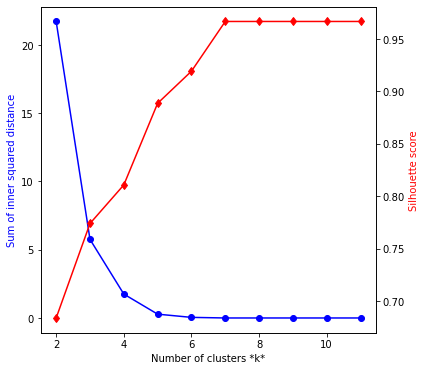

In [50]:
# Evaluate K-means first to choose a k value
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Select the features to feed into algorithm
candidates_kmeans = df_cincinatti_restaurants_types_mean[['Latin American', 'Non Latin American']]
candidates_std = StandardScaler().fit_transform(candidates_kmeans)

sse = []
sil = []
list_k = list(range(2, 12))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(candidates_std)
    sse.append(km.inertia_)
    sil.append(silhouette_score(candidates_std, km.labels_))

fig, ax1 = plt.subplots(figsize=(6, 6))

ax2 = ax1.twinx()
ax1.plot(list_k, sse, 'bo-')
ax2.plot(list_k, sil, 'rd-')

ax1.set_xlabel(r'Number of clusters *k*')
ax1.set_ylabel('Sum of inner squared distance', color='b')
ax2.set_ylabel('Silhouette score', color='r')

plt.show()

From the previous graph we can see that a good value for k will be 6, so we are going to classify each neighborhood using this value as an input for the KMean fuction. Let's see the result next.

In [52]:
# set number of clusters
kclusters = 6

df_cincinatti_restaurants_types_clustering = df_cincinatti_restaurants_types_mean.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cincinatti_restaurants_types_clustering)
kmeans.labels_

array([0, 0, 0, 3, 5, 0, 0, 4, 3, 1, 0, 0, 0, 2, 0, 5, 0, 4, 0, 0, 0, 4,
       0, 4, 2, 0, 0, 2, 0, 2], dtype=int32)

Now we are going to set the cluster assigned by the algorithms to a new dataframe where we are going to join the cluster number and the neighborhoods. Let's name the new dataframe <code>df_neighborhoods_clustered</code>.

We are going to add also the neighborhoods coordinates to each neighborhood to plot them in a Folium map.

In [53]:
df_neighborhoods_clustered = df_cincinatti_restaurants_types_mean
# add the cluster assigned to each neighborhood
df_neighborhoods_clustered['Cluster'] = kmeans.labels_

# add to the new dataframe the latitude and longitude of each neighborhood
df_cincinnati_neighborhoods.set_index("Neighborhood")
df_neighborhoods_clustered.set_index("Neighborhood")
df_neighborhoods_clustered_with_coordinates = pd.merge(df_neighborhoods_clustered, df_cincinnati_neighborhoods, on="Neighborhood")
df_neighborhoods_clustered_with_coordinates

,Neighborhood,Latin American,Non Latin American,Cluster,Latitude,Longitude
0,CUF,0.000000,1.000000,0,39.13034985,-84.5293513923621
1,California,0.000000,1.000000,0,39.0652059,-84.4272386
2,Camp Washington,0.000000,1.000000,0,39.1369816,-84.5371682
3,Carthage,0.500000,0.500000,3,39.1960281,-84.4786183
4,Clifton,0.250000,0.750000,5,39.1449517,-84.5202257
5,College Hill,0.000000,1.000000,0,39.2022803,-84.5471665
6,Columbia-Tusculum,0.000000,1.000000,0,39.1154346,-84.4396462
7,Corryville,0.166667,0.833333,4,39.1318601,-84.506554
8,Downtown,0.500000,0.500000,3,39.1006666,-84.51948
9,East Price Hill,1.000000,0.000000,1,39.1100594,-84.5638329


Now we can create a Folium map to display the neighborhoods clustered, and give us an idea of the distribution and classification of each neighborhood.

In [55]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_neighborhoods_clustered_with_coordinates['Latitude'], df_neighborhoods_clustered_with_coordinates['Longitude'], df_neighborhoods_clustered_with_coordinates['Neighborhood'], df_neighborhoods_clustered_with_coordinates['Cluster']):
    cluster = int(cluster)
    lat = float(lat)
    lon = float(lon)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #label=""
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In the previous map we can give us an idea of how the neighborhoods are clustered using the K-mean algorithm. Now we can see how many Latin American and non-Latin American restaurans exists into each cluster. Lets create a new dataframe to get this data.

In [58]:
df_cincinatti_restaurants_types_count.set_index("Neighborhood")
df_result_cincinatti_restaurants_count = pd.merge(df_neighborhoods_clustered_with_coordinates, df_cincinatti_restaurants_types_count, on="Neighborhood")
columns_name = ["Neighborhood", "Latin American (Mean)", "Non Latin American (Mean)", "Cluster", "Latitude", "Longitude", "Latin American (Count)", "Non Latin American (Count)"]
df_result_cincinatti_restaurants_count.columns = columns_name
df_result_cincinatti_restaurants_count

,Neighborhood,Latin American (Mean),Non Latin American (Mean),Cluster,Latitude,Longitude,Latin American (Count),Non Latin American (Count)
0,CUF,0.000000,1.000000,0,39.13034985,-84.5293513923621,0,1
1,California,0.000000,1.000000,0,39.0652059,-84.4272386,0,1
2,Camp Washington,0.000000,1.000000,0,39.1369816,-84.5371682,0,2
3,Carthage,0.500000,0.500000,3,39.1960281,-84.4786183,1,1
4,Clifton,0.250000,0.750000,5,39.1449517,-84.5202257,2,6
5,College Hill,0.000000,1.000000,0,39.2022803,-84.5471665,0,4
6,Columbia-Tusculum,0.000000,1.000000,0,39.1154346,-84.4396462,0,5
7,Corryville,0.166667,0.833333,4,39.1318601,-84.506554,1,5
8,Downtown,0.500000,0.500000,3,39.1006666,-84.51948,1,1
9,East Price Hill,1.000000,0.000000,1,39.1100594,-84.5638329,1,0


Now using the previous dataframe we can create a summary of how many restaurants Latin American and non-Latin American exists in each cluster.

In [59]:
df_graph = df_result_cincinatti_restaurants_count
df_bar_chart = df_graph.groupby("Cluster").sum()
df_bar_chart.reset_index(inplace=True)
df_bar_chart

,Cluster,Latin American (Mean),Non Latin American (Mean),Latin American (Count),Non Latin American (Count)
0,0,0.000000,17.000000,0,33
1,1,1.000000,0.000000,1,0
2,2,1.333333,2.666667,4,8
3,3,1.000000,1.000000,2,2
4,4,0.733333,3.266667,6,26
5,5,0.500000,1.500000,3,9


With the previous data with can create a bar chart to see more easier how the restaurants and distributed in each cluster.

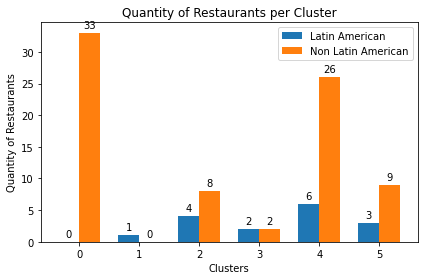

In [61]:
labels = df_bar_chart["Cluster"]
latin_american_count = df_bar_chart["Latin American (Count)"]
non_latin_american_count = df_bar_chart["Non Latin American (Count)"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, latin_american_count, width, label='Latin American')
rects2 = ax.bar(x + width/2, non_latin_american_count, width, label='Non Latin American')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Quantity of Restaurants')
ax.set_xlabel('Clusters')
ax.set_title('Quantity of Restaurants per Cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In this chart, we can see that a good option could be to use cluster 1 or 3 since this cluster has the less quantity of restaurants which the minority are Latin American restaurants. Let's list the neighborhoods that belong to each one of the clusters.

In [62]:
cluster_1 = df_neighborhoods_clustered.loc[df_neighborhoods_clustered['Cluster'] == 1]
cluster_1['Neighborhood']

9    East Price Hill
Name: Neighborhood, dtype: object

In [63]:
cluster_3 = df_neighborhoods_clustered.loc[df_neighborhoods_clustered['Cluster'] == 3]
cluster_3['Neighborhood']

3    Carthage
8    Downtown
Name: Neighborhood, dtype: object

From the previous analysis, we can say that good options for opening a Latin American restaurant are the neighborhoods East Price Hill, Carthage, or Downton which are the neighborhoods that belong to clusters 1 and 3. With this, we conclude our analysis.

<h2 id="results">Results and Discussion</h2><hr>
The analysis we made was focused on identifying all restaurants that are 500 meters around the central coordinates of each of the neighborhoods. After getting this data we classify each of the restaurants in Latin American or non-Latin American. This was executed only for cities in Cincinnati, and we get a result that three neighborhoods are good options to open a Latin American restaurant.

We have to keep in mind that this project doesn't imply that the neighborhoods identified as options are in fact the best place to open a new restaurant, since we should have other things in mind, as the Latin American population in each of these neighborhoods or around them. Also have to keep in mind that we only analyzed the venues that were 500 meters around the central point of the neighborhood, so probably there were more restaurants that we could be analyzed. Another point to take into count is the price for rent for a restaurant in these neighborhoods. What we want to left clear is that the resulting locations are only starting points for more detailed analysis.

<h2 id="conclusion">Conclusion</h2><hr>
The purpose of this project was to identify neighborhoods with a low number of Latin American and non-Latin American restaurants in order to make visible to all the persons' interested possible places to open a Latin American restaurant. To do this we list all restaurants around 500 meters from the central location for each neighborhood, group these restaurants as Latin American and non-Latin American, and segment them for each cluster.

In the end, the person who will take de decision to open a new Latin American restaurant should have in mind other variables as rent, Latin American population near each neighborhood.